<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [16]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.dates as mdates
import pandas as pd
from scipy.stats import norm
from scipy.optimize import curve_fit
from datetime import timedelta, datetime

In [19]:
ratio_mean_guess = 0.78
ratio_std_guess = 0.02

# Open DataFrame

In [3]:
upper_int = 100000
lower_int = 0

## Pulse Data

Open up all runs.

In [4]:
dfs = []
path = 'datafiles/jan_3_2019'
for filename in os.listdir(path):
    if filename.endswith(".csv"):
        df = pd.read_csv(path+'/'+filename, sep=',', index_col=0).astype(float)
        df['ratio']=df['Integral 1200']/df['Integral 7400']
        df.index = pd.to_datetime(df.index,unit='s')-timedelta(hours=7)
        
        df = df[(df['ratio']<1) & (df['ratio']>0)] #should not have to do this
        df = df[(df['Integral 7400']<upper_int) & (df['Integral 7400']>lower_int)] #should not have to do this
        dfs.append(df)

Get beginning and end of each run. Need to subtract 1 hour because computer did not account for the time change.

In [5]:
begins = [df.index.values[0]-np.timedelta64(1,'h') for df in dfs]
ends = [df.index.values[-1]-np.timedelta64(1,'h') for df in dfs]

# Preliminary Plot

Plot energy ratios.

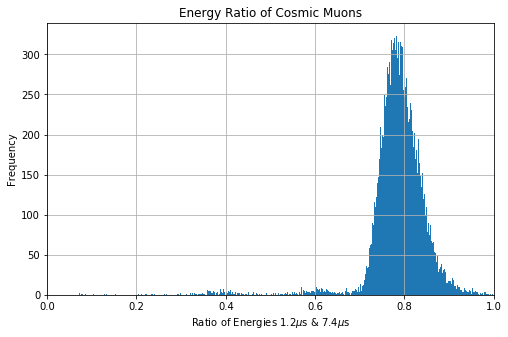

In [6]:
fig, ax = plt.subplots(figsize=(8,5))

dfs[0]['ratio'].hist(bins=500, ax=ax)

ax.set_xlim(0,1)
ax.set_xlabel('Ratio of Energies 1.2$\mu$s & 7.4$\mu$s')
ax.set_ylabel('Frequency')
ax.set_title('Energy Ratio of Cosmic Muons')
plt.show()

Plot energy deposited.

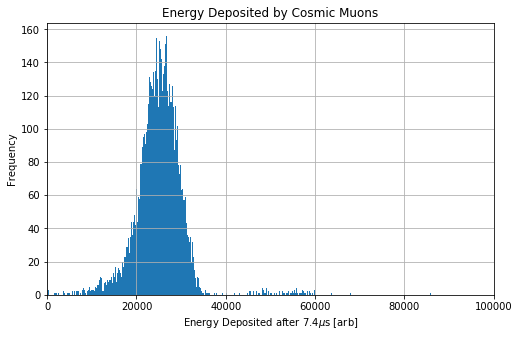

In [7]:
fig, ax = plt.subplots(figsize=(8,5))

dfs[0]['Integral 7400'].hist(bins=1000, ax=ax)
ax.set_xlim(0,100000)
ax.set_xlabel('Energy Deposited after 7.4$\mu$s [arb]')
ax.set_ylabel('Frequency')
ax.set_title('Energy Deposited by Cosmic Muons')

plt.show()

# Fitting Methods to Find the Mode

In [8]:
df = dfs[0]

Define the normal curve:

In [9]:
def norm(x, u, sig, amp):
    return amp*np.exp(-((x-u)**2)/(2*sig**2))

Fit the histogram data between 0.75 and 0.8.

In [10]:
mask = (df['ratio']>0.75) & (df['ratio']<0.8)

h, x , _ = plt.hist(df['ratio'][mask], bins=25); plt.close()
x = x[:-1]

p0  = (ratio_mean_guess, ratio_std_guess, np.max(h))
popt, pcov = curve_fit(norm, x, h, p0=p0)
perr = np.sqrt(np.diag(pcov))

Initial Plot.

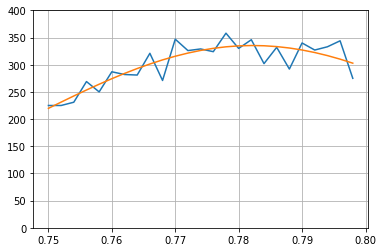

In [11]:
fig, ax = plt.subplots()

ax.plot(x,h)
ax.plot(x,norm(x, popt[0], popt[1], popt[2]), label='Fit')

ax.set_ylim(0, 400)
ax.grid()

Do plotting:

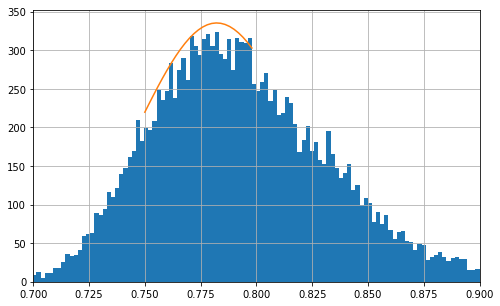

In [12]:
fig, ax = plt.subplots(figsize=(8,5))

y= df['ratio'].hist(bins=500, ax=ax)
ax.plot(x,norm(x, popt[0], popt[1], popt[2]), label='Fit')

ax.set_xlim(0.7,0.9)
plt.show()

# Automation

In [20]:
def mode_ratio(df):
    mask = (df['ratio']>0.75) & (df['ratio']<0.8)

    h, x , _ = plt.hist(df['ratio'][mask], bins=25); plt.close()
    x = x[:-1]

    p0  = (ratio_mean_guess, ratio_std_guess, np.max(h))
    popt, pcov = curve_fit(norm, x, h, p0=p0)
    perr = np.sqrt(np.diag(pcov))
    
    return popt[0], perr[0]

In [26]:
mode_ratio(dfs[0])

(0.7821861674794692, 0.0018515098995575037)

# 2D Histogram Stuff:

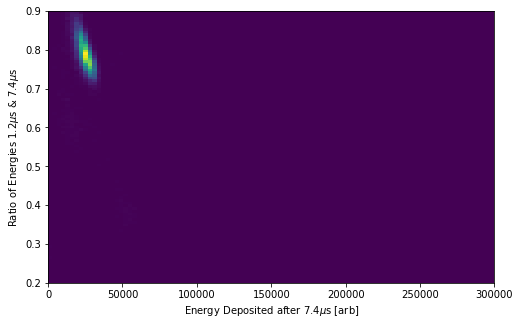

In [24]:
fig, ax = plt.subplots(figsize=(8,5))

ax.hist2d(df['Integral 7400'].values, df['ratio'].values,
          range=np.array([(0, 300000), (0.2, 0.9)]), bins=100)

ax.set_xlabel('Energy Deposited after 7.4$\mu$s [arb]')
ax.set_ylabel('Ratio of Energies 1.2$\mu$s & 7.4$\mu$s')

plt.show()